In [ ]:
# default_exp analyses

# The Lag-Contiguity Effect in Repetition Data
The lag-contiguity effect illustrates how episodic associations are graded, exhibiting power-function decay with increasing lag. 
Recall of an item has a tendency to evoke not only adjacent list items, but other nearby items as well. 
In addition, episodic associations appear to be a|symmetrical, favoring retrieval of items in the forward order.

Here we extend on previous implementations to ensure recall rates are successfully measured and visualized when study lists can include two presentations of study items. 

## Contrast With Stochastic Approach Demoed in Lohnas & Kahana (2014)

> For lists containing repeated spaced items, the lags for such an item is ambiguous. For instance, the transition between an item presented in serial position 5 to an item presented in serial positions 3 and 9 could be considered a lag of −2 or +4. 

I kind of disagree with the specifics of this framework. The lags are not ambiguous -- we know what they are. Rather, they are numerous, and to account for that we can just track each lag in our analysis.

> For any transition with an ambiguous lag (i.e. a transition including a repeated item), we randomly selected the lag value from the set of possible lags. 

The lag-CRP is a ratio of lag transitions that were made over transitions that could have been made across each output in a dataset. However, for lists containing repeated spaced items, the lags for such an item is numerous. For instance, the transition between an item presented in serial position 5 to an item presented in serial positions 3 and 9 is both a lag of −2 and of +4. In our tally of actual and possible lag transitions, we accordingly count both these values. Relating this approach to the example above, a lag transition of -2 and of +4 is possible (and actual) for the considered output.

Randomly selecting the lag value from the set of possible lags for each analysis and aggregating over multiple replicates will (probably) converge to this result. However, that approach is imprecise, nondeterministic, and takes longer to run.

## Data Preparation

In [ ]:
from compmemlearn.datasets import prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


## Function
That recalled items can have two study positions forces us to complicate the function. Along with the scenario where the current and the previous item have just one relevant serial lag to consider, we must also consider the case where there are two serial lags to consider when either the current item or the previous item had two serial positions. Then there's one more scenario -- when both the the current and the previous item were encountered twice during encoding. This corresponds with four serial lags to consider. 

How do we weigh these? The approach in the SPC was just to interpret the description of the analysis literally. In the SPC, we tracked the probability of recalling an item given that it was studied at each selected position -- even if it was also studied at some other position. Here, we'll do the same thing, except using lag instead of study position. Extensions of this analysis can exclude items on chosen bases, but this gets us a solid general foundation. 

To achieve this, we have to change how we track lag lag across trials (in `actual`) so that lags can occur with multiple lags simultaneously.

We must also change how we track changes to the `pool` of possible lag lags. This probably requires adding some representation of items that have positions as attributes and are looped across to identify relevant lags. 

`previous_recall` can identify those items.

In [ ]:
from compmemlearn.analyses import recall_by_second_study_position, recall_by_all_study_positions

In [ ]:
# export

from numba import njit
from numba import int32
import numpy as np
from compmemlearn.datasets import find_first


@njit(nogil=True)
def fast_mixed_crp(trials, presentations):
    
    list_length = len(presentations[0])
    lag_range = list_length - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1) # number of recalls per trial
    
    # compute actual serial lag b/t recalls, considering all possible positions
    alt_presentations = np.fliplr(presentations)
    alt_trials = recall_by_second_study_position(trials, presentations)
    actual_lags = np.zeros((4, len(trials), len(trials[0])-1), dtype=int32)
    actual_lags[0] = trials[:, 1:] - trials[:, :-1]
    actual_lags[1] = trials[:, 1:] - alt_trials[:, :-1]
    actual_lags[2] = alt_trials[:, 1:] - trials[:, :-1]
    actual_lags[3] = alt_trials[:, 1:] - alt_trials[:, :-1]
    
    # if actual[0, x, y] == actual[2, x, y] (or 1, 3) then lagged-to item has 1 presentation
    # if actual[0, x, y] == actual[1, x, y] (or 2, 3 respectively) then lagged-from item has 1 pres
    # avoid counting single presentations twice by giving those lags a value of 0
    previous_item_equivalence = actual_lags[0] == actual_lags[2]
    current_item_equivalence = actual_lags[0] == actual_lags[1]
    either_item_equivalence = np.logical_or(previous_item_equivalence, current_item_equivalence)

    for i in range(len(actual_lags[0])):
        actual_lags[1, i][current_item_equivalence[i]] = 0
        actual_lags[2, i][previous_item_equivalence[i]] = 0
        actual_lags[3, i][either_item_equivalence[i]] = 0
        
    # we add lag_range to have result identify indices in total_ to bin counts
    actual_lags += lag_range
    
    for trial_index in range(len(trials)):
        
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((item_count, 2))
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            possible_positions[item, 0] = find_first(item, presentations[trial_index])
            possible_positions[item, 1] = list_length - find_first(item, alt_presentations[trial_index]) -1
        
        for recall_index in range(terminus[trial_index]):
            
            # track possible and actual lags
            if recall_index > 0:

                # we add to actual_lags total for each lag transition made for this recall
                total_actual_lags[actual_lags[:, trial_index, recall_index-1]] += 1
                
                # item indices don't help track lags anymore
                # so more complex calculation needed to identify possible lags given previous item
                possible_lags = np.zeros((4, len(possible_items)), dtype=int32)
                possible_lags[0] = possible_positions[possible_items, 0] - possible_positions[previous_item, 0]
                possible_lags[1] = possible_positions[possible_items, 0] - possible_positions[previous_item, 1]
                possible_lags[2] = possible_positions[possible_items, 1] - possible_positions[previous_item, 0]
                possible_lags[3] = possible_positions[possible_items, 1] - possible_positions[previous_item, 1]
                
                # avoid redundant counting of single presentations
                previous_item_equivalence = possible_lags[0] == possible_lags[2]
                current_item_equivalence = possible_lags[0] == possible_lags[1]
                either_item_equivalence = np.logical_or(previous_item_equivalence, current_item_equivalence)
                possible_lags[1][current_item_equivalence] = 0
                possible_lags[2][previous_item_equivalence] = 0
                possible_lags[3][either_item_equivalence] = 0
    
                possible_lags += lag_range
                total_possible_lags[possible_lags.flatten()] += 1
                
            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            possible_items = possible_items[possible_items != previous_item]
    
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[lag_range] = 0
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

In [ ]:
# export

@njit(nogil=True)
def flex_mixed_crp(trials, presentations, max_repeats=2):
    
    list_length = len(presentations[0])
    lag_range = list_length - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1) # number of recalls per trial
    recall_by_study_position = recall_by_all_study_positions(trials, presentations, max_repeats)
    
    for trial_index in range(len(trials)):
        
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((item_count, max_repeats), dtype=int32)
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            pos = np.nonzero(presentations[trial_index] == item)[0] + 1
            possible_positions[item, :len(pos)] = pos
            
        for recall_index in range(terminus[trial_index]):
            
            current_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            
            # track possible and actual lags
            if recall_index > 0:
                
                # item indices don't help track lags anymore
                # so more complex calculation needed to identify possible lags given previous item
                current_index = np.nonzero(possible_items==current_item)[0]
                possible_lags = np.zeros((len(recall_by_study_position) ** 2, len(possible_items)), dtype=int32)

                index = 0
                for x in range(len(recall_by_study_position)):
                    for y in range(len(recall_by_study_position)):
                        if possible_positions[previous_item, y] > 0:
                        
                            possible_lags[index] = possible_positions[
                                possible_items, x] - possible_positions[previous_item, y]
                            
                            # if tracked position is 0, then we don't actually want to count it in our lags
                            possible_lags[index][possible_positions[possible_items, x] == 0] = 0
                        
                        index += 1

                possible_lags += lag_range
                total_actual_lags[possible_lags[:, current_index].flatten()] += 1
                total_possible_lags[possible_lags.flatten()] += 1
                        

            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = current_item
            possible_items = possible_items[possible_items != previous_item]
                    
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[lag_range] = 0
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

## Demo

### Comparison With Regular `fast_csp` Using Control Lists

In [ ]:
from compmemlearn.analyses import fast_crp

fast_crp(trials[list_types==1], 40) == fast_mixed_crp(trials[list_types==1], presentations[list_types==1])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [ ]:
%timeit fast_mixed_crp(trials[list_types==1], presentations[list_types==1])

15.7 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit fast_crp(trials[list_types==1], 40)

3.25 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit flex_mixed_crp(trials[list_types==1], presentations[list_types==1])

20.9 ms ± 336 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
condition = 4
flex_mixed_crp(trials[list_types==condition], presentations[list_types==condition]) == fast_mixed_crp(trials[list_types==condition], presentations[list_types==condition])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [ ]:
flex_mixed_crp(trials[list_types==condition], presentations[list_types==condition])

array([0.04545455, 0.07741935, 0.02702703, 0.03448276, 0.01239669,
       0.01867572, 0.01267606, 0.0255164 , 0.0311493 , 0.02812803,
       0.02410714, 0.02390767, 0.02356638, 0.01918819, 0.02116041,
       0.02271252, 0.02799757, 0.02669762, 0.0268757 , 0.0295858 ,
       0.02862883, 0.02987952, 0.02465116, 0.0199027 , 0.02997859,
       0.02920609, 0.03033885, 0.03862333, 0.04053552, 0.04422869,
       0.04406539, 0.05585831, 0.0589584 , 0.05534106, 0.0639848 ,
       0.06148171, 0.08683975, 0.09879092, 0.17528821, 0.        ,
       0.28192131, 0.12563791, 0.08370591, 0.06432161, 0.06537967,
       0.05540897, 0.05018991, 0.04840941, 0.03874644, 0.0437536 ,
       0.03453365, 0.03611195, 0.0264234 , 0.03119922, 0.0254065 ,
       0.01907074, 0.02382671, 0.02185995, 0.02243714, 0.01709742,
       0.01704782, 0.01742919, 0.0191344 , 0.01429933, 0.01544594,
       0.01411396, 0.02090209, 0.01302546, 0.01519949, 0.01491525,
       0.01538462, 0.01579779, 0.0123131 , 0.01383399, 0.01030

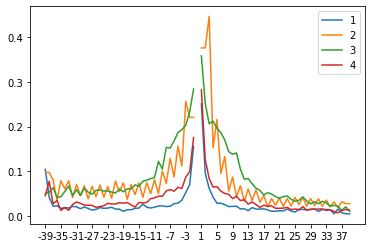

In [ ]:
import matplotlib.pyplot as plt

for condition in range(4):
    test_crp= fast_mixed_crp(trials[list_types==condition+1], presentations[list_types==condition+1])
    test_crp[len(presentations[0])-1] = np.nan
    plt.plot(np.arange(len(test_crp)), test_crp, label=str(condition+1))
    plt.xticks(np.arange(0, len(test_crp), 4), np.arange(0, len(test_crp), 4) - 39)
    
plt.legend()